# Autonomous Driving (Part 2)

In this assignment, the goal is to use the training data from the assignment Autonomous Driving (Part 1) for learning to drive autonomously. For that reason, we will use the car racing example from [Gymnasium](https://gymnasium.farama.org). As showed in the last assignment, Gym is a framework for developing reinforcement learning approaches. It supports different types of agents. Here, we will focus on vehicles.

*Important*: You need to install [Gymnasium](https://gymnasium.farama.org) in your system. The installation can be done with pip or by installing from the sources. More information at [https://pypi.org/project/gymnasium/](https://pypi.org/project/gymnasium/)).

*Important*: The Python version of Gym and the Python version of PyTorch has to be the same. This is an important requirement for creating the inference pipeline function.

Note that all scripts should be self-contained and executed on *any* machine that has required libraries installed.



## 1. Car Racing Model Learning

In this exercise, a car drives on a track in a racing environment. The car can turn left, right, accelerate or decelerate. The input is an image with 96x96 pixels or 96x84, if you removed the black bar on the bottom of the image. In addition, rewards are given based on the driving behavior. We are not interested in the rewards in this task. The aim of this exercise is to make use of the training data from part 1 to train a deep neural network to control the vehicle. 

*Task Output*: The training set of 5000 car racing images should be split into 60% training, 20% validation and 20% test samples. All subsets should include consecutive frames. The 20% test samples should include a maneuver (accelerate, decelerate, go-right/left). The neural network architecture can be chosen based on the previous classification assignment on MNIST (CNN model). However, the output of the network should be a softmax with 5 classes (accelerate, decelerate, turn left, turn right, no actions). At this point, data augmentation should not be used during training. The output of the exercise should be a plot of the training, validation and test set loss over time and the accuracy over time. The model has to be trained with [early stopping](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/) using _min_delta=0.0_ and _patience=3_.

*Important*: The scripts should be **self-contained**. The data augmentation should be dynamically implemented, i.e it is applied when the data from the mini-batch is loaded.

Train size: 3000, Validation size: 1000, Test size: 1000
Batch 1:
Image batch shape: torch.Size([32, 3, 96, 96])
Action batch shape: torch.Size([32])


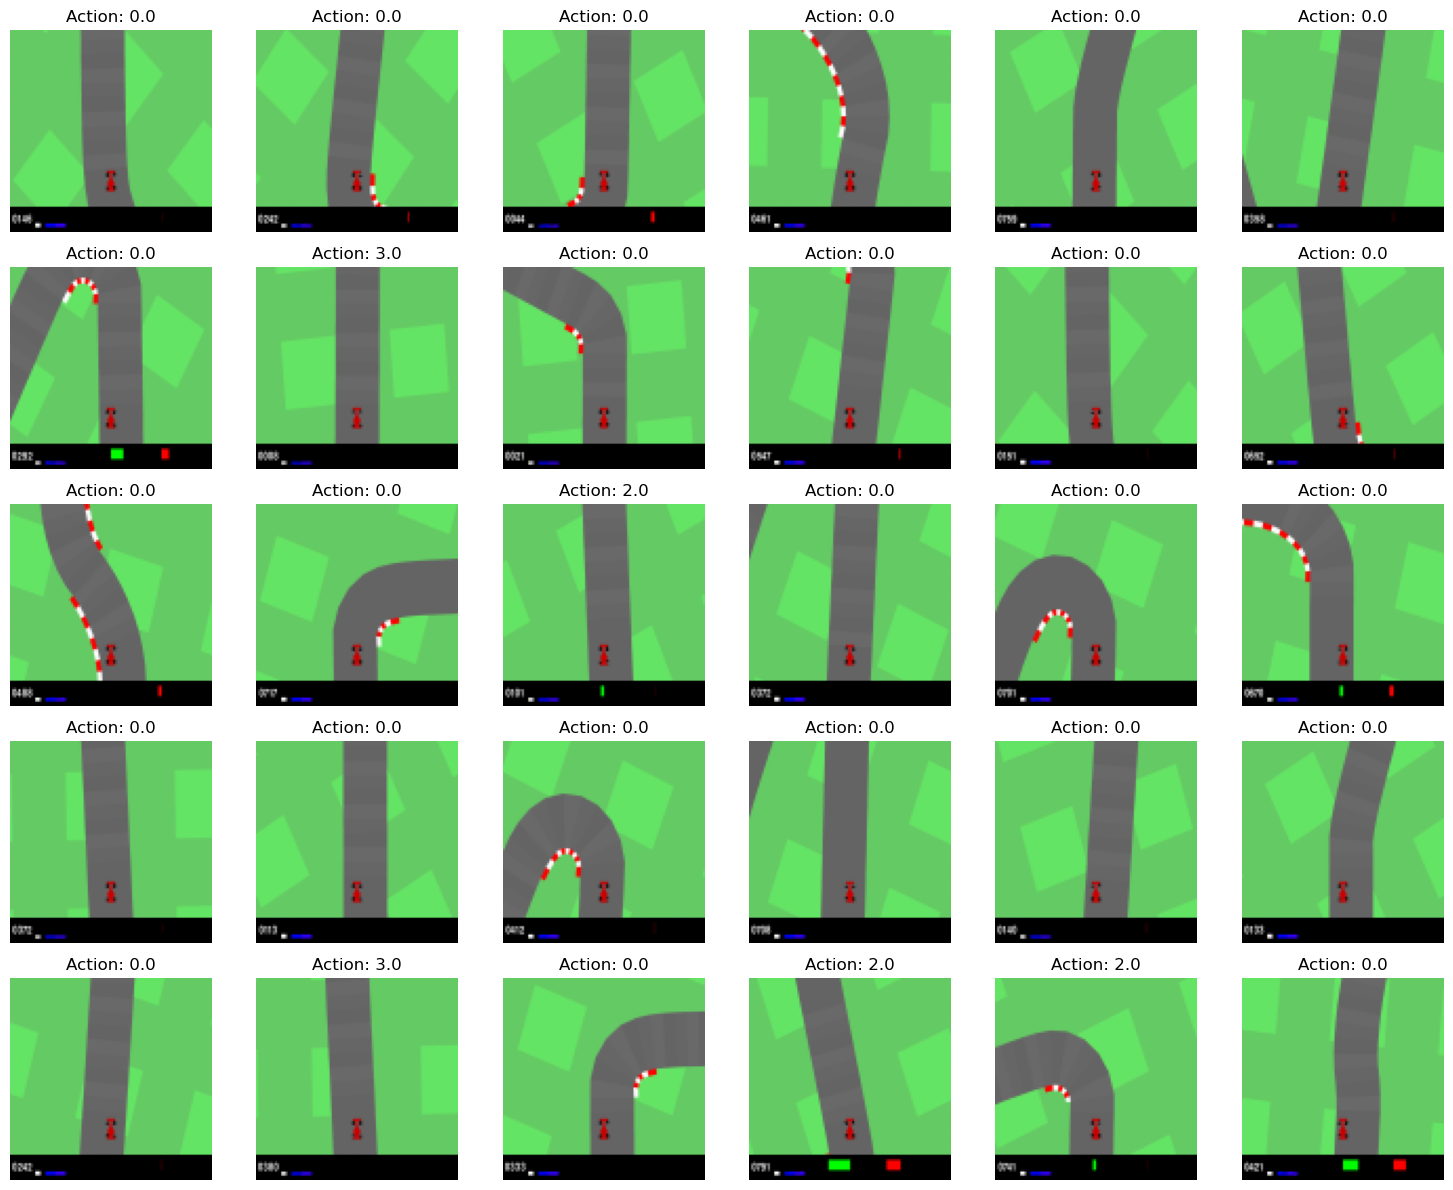

In [1]:
#load the dataset and split it into train, validation and test sets

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import random
from torchvision import transforms
from PIL import Image
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

class CarRacingDataset(Dataset):
    def __init__(self, npz_file, augmentations=True, horizontal_flip=False, vertical_flip=False, street_color_change=False):
        """
        Args:
            npz_file (str): Path to the .npz file containing 'frames' and 'actions'.
            augmentations (bool): Whether to apply augmentations.
            horizontal_flip (bool): Whether to apply horizontal flip.
            vertical_flip (bool): Whether to apply vertical flip.
            street_color_change (bool): Whether to apply street color change.
        """
        data = np.load(npz_file)
        self.frames = data['frames']
        self.actions = data['actions']
        self.augmentations = augmentations
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.street_color_change = street_color_change
        self.to_pil = transforms.ToPILImage()
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.frames)

    def _apply_horizontal_flip(self, image):
        if random.random() < 0.5 and self.horizontal_flip and self.augmentations:
            return image.transpose(Image.FLIP_LEFT_RIGHT)
        return image

    def _apply_vertical_flip(self, image):
        if random.random() < 0.5 and self.vertical_flip and self.augmentations:
            return image.transpose(Image.FLIP_TOP_BOTTOM)
        return image

    def _apply_street_color_change(self, image):
        if random.random() < 0.5 and self.street_color_change and self.augmentations:
            # Define the gray and brown color ranges
            gray_min = [100, 100, 100]
            gray_max = [150, 150, 150]
            brown_min = [90, 60, 30]
            brown_max = [150, 100, 60]

            img_np = np.array(image)
            mask = np.all((img_np >= gray_min) & (img_np <= gray_max), axis=2)
            # Generate a random brown color for each channel independently
            brown_color = np.array([random.randint(brown_min[i], brown_max[i]) for i in range(3)], dtype=np.uint8)
            img_np[mask] = brown_color
            return Image.fromarray(img_np)
        return image

    def __getitem__(self, idx):
        frame = self.frames[idx]
        action = self.actions[idx]

        image = self.to_pil(frame)

        image = self._apply_horizontal_flip(image)
        image = self._apply_vertical_flip(image)
        image = self._apply_street_color_change(image)

        image = self.to_tensor(image)
        action = torch.tensor(action, dtype=torch.float32)

        return image, action

if __name__ == '__main__':
    # Assuming you have an 'all_episodes.npz' file in the same directory
    npz_file_path = 'all_episodes_disc.npz'

    # create the Dataset
    dataset = CarRacingDataset(
        npz_file=npz_file_path,
        augmentations=False, #making augmentations to false here renders the other parameters useless
        horizontal_flip=True,
        vertical_flip=True,
        street_color_change=True
    )

    # Split the dataset into train, validation, and test sets
    train_size = int(0.6 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
    val_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size+val_size))
    test_dataset = torch.utils.data.Subset(dataset, range(train_size+val_size, len(dataset)))

    print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Iterate through a few batches to see the data
    for i, (images, actions) in enumerate(dataloader):
        print(f"Batch {i+1}:")
        print("Image batch shape:", images.shape)
        print("Action batch shape:", actions.shape)

        # You can add visualization code here for the first few images in the first batch
        if i == 0:
            import matplotlib.pyplot as plt
            num_visualize = min(30, images.shape[0])
            fig, axes = plt.subplots(5, 6, figsize=(15, 12))
            axes = axes.flatten()
            for j in range(num_visualize):
                img = images[j].permute(1, 2, 0).numpy()
                ax = axes[j]
                ax.imshow(img)
                ax.set_title(f"Action: {actions[j].numpy()}")
                ax.axis('off')
            plt.tight_layout()
            plt.show()
            break # Visualize only the first batch

        if i >= 2: # Stop after a few batches for demonstration
            break

Using device: cuda
Epoch 1: Train Loss=0.8793, Val Loss=0.8746, Val Acc=73.20%
Test Loss: 0.7481, Test Accuracy: 81.00%
Epoch 2: Train Loss=0.7403, Val Loss=0.7976, Val Acc=73.20%
Test Loss: 0.6510, Test Accuracy: 81.00%
Epoch 3: Train Loss=0.5578, Val Loss=0.5645, Val Acc=77.80%
Test Loss: 0.4549, Test Accuracy: 82.90%
Epoch 4: Train Loss=0.4159, Val Loss=0.4646, Val Acc=82.70%
Test Loss: 0.3713, Test Accuracy: 86.60%
Epoch 5: Train Loss=0.3395, Val Loss=0.3880, Val Acc=87.90%
Test Loss: 0.3238, Test Accuracy: 91.20%
Epoch 6: Train Loss=0.3199, Val Loss=0.3330, Val Acc=89.50%
Test Loss: 0.2841, Test Accuracy: 92.20%
Epoch 7: Train Loss=0.2911, Val Loss=0.3814, Val Acc=87.20%
Test Loss: 0.3004, Test Accuracy: 89.90%
Epoch 8: Train Loss=0.2406, Val Loss=0.2635, Val Acc=91.40%
Test Loss: 0.2307, Test Accuracy: 93.30%
Epoch 9: Train Loss=0.2338, Val Loss=0.2617, Val Acc=92.10%
Test Loss: 0.2343, Test Accuracy: 93.90%
Epoch 10: Train Loss=0.2547, Val Loss=0.2048, Val Acc=92.20%
Test Loss: 

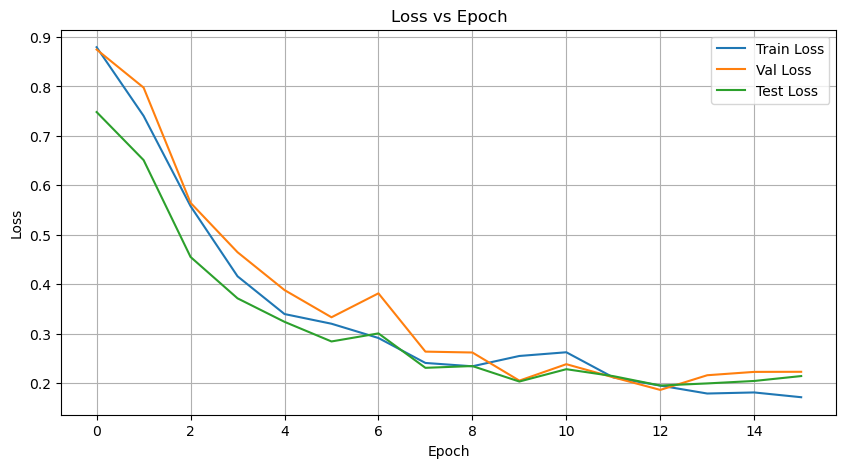

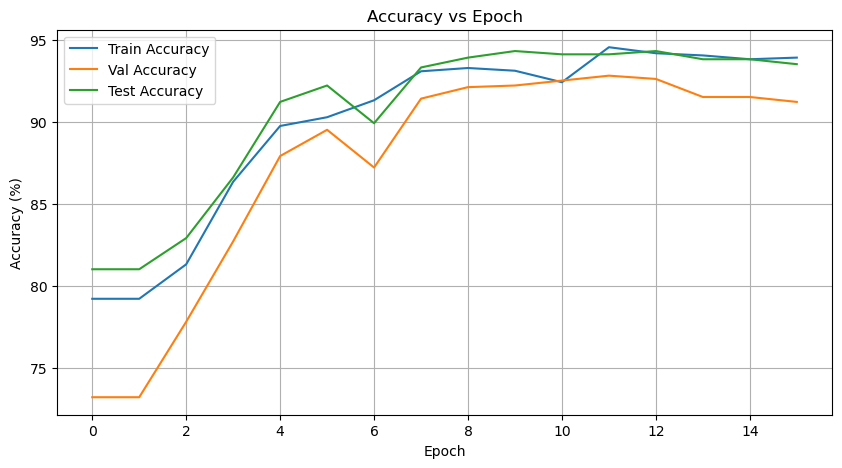

In [2]:
#define network architecture

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define CNN model for 96x96 images and 5 class o/p
class CarCNN(nn.Module):
    def __init__(self):
        super(CarCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=2, padding=2),  # 96x96 → 48x48
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, stride=2, padding=2),  # 48x48 → 24x24
            nn.ReLU(),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),  # 24x24 → 12x12
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 128),
            nn.ReLU(),
            nn.Linear(128, 5)  # 5 classes
        )

    def forward(self, x):
        return self.net(x)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, optimizer, and loss function
model = CarCNN().to(device)
LR = 0.001
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

#configure the early stopping criterion
patience = 3
min_delta = 0.0
best_val_loss = float('inf')
patience_counter = 0

# Training loop
num_epochs = 50
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.long().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.long().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_accuracies[-1]:.2f}%")

    # Test evaluation
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.long().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1) # alternatively: apply softmax if we need probabilities of all the 5 classes
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Early stopping
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Save the model
torch.save(model.state_dict(), 'driving_model.pth')

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid()
plt.show()

## 2. Data Augmentation for Car Racing

This exercise is an extension of the previous one. Here, the deep neural network has to be trained with data augmentation. The same data split from part 1 will be applied here.

*Task Output*: Repeat the training process with data augmentation. Each augmentation should be applied with probability 20% inside the mini-batch loading. The augmentations that have to be implemented are horizontal flipping and random rotation (up to 20 degrees). The output of the exercise should be a plot of the training, validation and test set loss over time and the accuracy over time. The model has to be trained with early stopping using _min_delta=0.0_ and _patience=3_. Finally, the loss and accuracy of training with and without augmentation should be visualized in the same plot.

*Important*: The scripts should be **self-contained**. The data augmentation should be dynamically implemented, i.e it is applied when the data from the mini-batch is loaded.

In [3]:
#modify the previously defined dataset class to include the new augmentations

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import random
from torchvision import transforms
from PIL import Image

class CarRacingDataset(Dataset):
    def __init__(self, npz_file, augmentations=True, horizontal_flip=False, random_rotation=False, vertical_flip=False, street_color_change=False):
        """
        Args:
            npz_file (str): Path to the .npz file containing 'frames' and 'actions'.
            augmentations (bool): Whether to apply augmentations.
            horizontal_flip (bool): Whether to apply horizontal flip.
            random_rotation (bool): Whether to apply random rotation (up to 20 degrees).
            vertical_flip (bool): Whether to apply vertical flip.
            street_color_change (bool): Whether to apply street color change.
        """
        data = np.load(npz_file)
        self.frames = data['frames']
        self.actions = data['actions']
        self.augmentations = augmentations
        self.horizontal_flip = horizontal_flip
        self.random_rotation = random_rotation
        self.vertical_flip = vertical_flip
        self.street_color_change = street_color_change
        self.to_pil = transforms.ToPILImage()
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.frames)

    def _apply_horizontal_flip(self, image):
        # Modified to use 20% probability as specified in the task
        if random.random() < 0.2 and self.horizontal_flip and self.augmentations:
            return image.transpose(Image.FLIP_LEFT_RIGHT)
        return image

    def _apply_random_rotation(self, image):
        # New augmentation method for random rotation up to 20 degrees
        if random.random() < 0.2 and self.random_rotation and self.augmentations:
            angle = random.uniform(-20, 20)  # Random angle between -20 and 20 degrees
            return image.rotate(angle)
        return image

    def _apply_vertical_flip(self, image):
        if random.random() < 0.2 and self.vertical_flip and self.augmentations:
            return image.transpose(Image.FLIP_TOP_BOTTOM)
        return image

    def _apply_street_color_change(self, image):
        if random.random() < 0.2 and self.street_color_change and self.augmentations:
            # Define the gray and brown color ranges
            gray_min = [100, 100, 100]
            gray_max = [150, 150, 150]
            brown_min = [90, 60, 30]
            brown_max = [150, 100, 60]

            img_np = np.array(image)
            mask = np.all((img_np >= gray_min) & (img_np <= gray_max), axis=2)
            # Generate a random brown color for each channel independently
            brown_color = np.array([random.randint(brown_min[i], brown_max[i]) for i in range(3)], dtype=np.uint8)
            img_np[mask] = brown_color
            return Image.fromarray(img_np)
        return image

    def __getitem__(self, idx):
        frame = self.frames[idx]
        action = self.actions[idx]

        image = self.to_pil(frame)

        image = self._apply_horizontal_flip(image)
        image = self._apply_random_rotation(image)  # Added this line to apply random rotation
        image = self._apply_vertical_flip(image)
        image = self._apply_street_color_change(image)

        image = self.to_tensor(image)
        action = torch.tensor(action, dtype=torch.float32)

        return image, action

Using device: cuda
Train size: 3000, Validation size: 1000, Test size: 1000
Epoch 1: Train Loss=0.8851, Val Loss=0.8675, Val Acc=73.20%
Test Loss: 0.7402, Test Accuracy: 81.00%
Epoch 2: Train Loss=0.6846, Val Loss=0.6976, Val Acc=75.80%
Test Loss: 0.5397, Test Accuracy: 82.10%
Epoch 3: Train Loss=0.5399, Val Loss=0.5920, Val Acc=78.50%
Test Loss: 0.4715, Test Accuracy: 82.70%
Epoch 4: Train Loss=0.4577, Val Loss=0.5090, Val Acc=83.00%
Test Loss: 0.4051, Test Accuracy: 87.00%
Epoch 5: Train Loss=0.3818, Val Loss=0.4025, Val Acc=87.60%
Test Loss: 0.3450, Test Accuracy: 89.90%
Epoch 6: Train Loss=0.3384, Val Loss=0.4408, Val Acc=87.50%
Test Loss: 0.3465, Test Accuracy: 90.50%
Epoch 7: Train Loss=0.3493, Val Loss=0.4000, Val Acc=88.70%
Test Loss: 0.3570, Test Accuracy: 90.30%
Epoch 8: Train Loss=0.3224, Val Loss=0.3521, Val Acc=89.50%
Test Loss: 0.3095, Test Accuracy: 91.90%
Epoch 9: Train Loss=0.3533, Val Loss=0.3574, Val Acc=88.20%
Test Loss: 0.2952, Test Accuracy: 91.20%
Epoch 10: Train

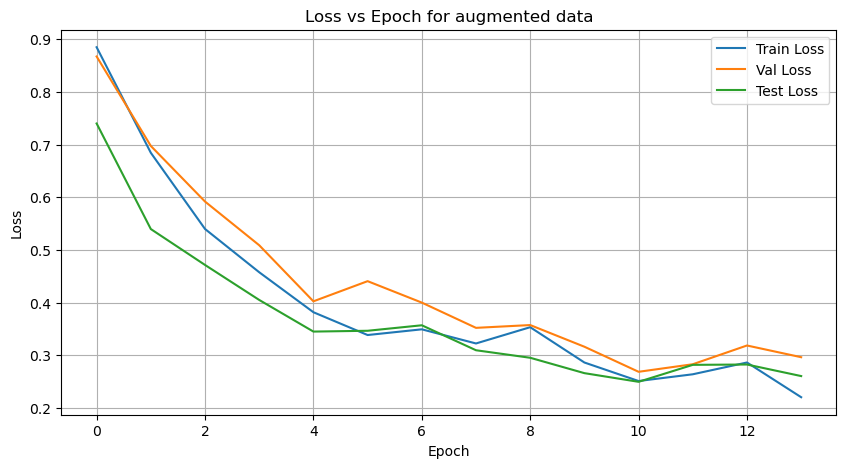

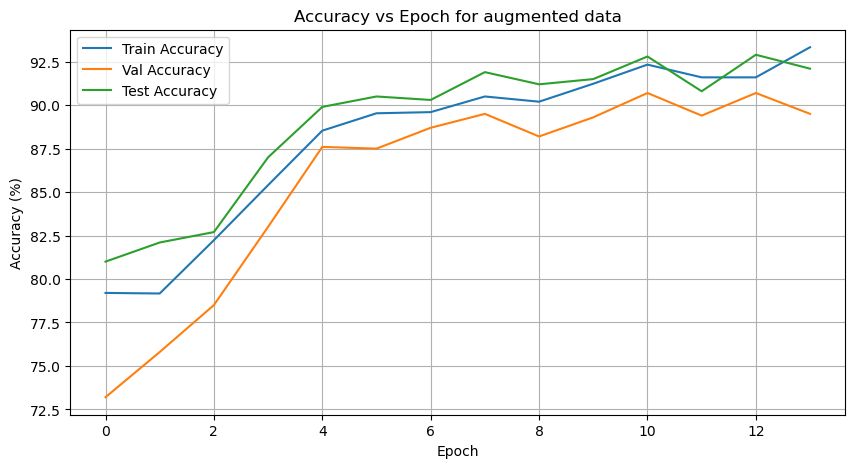

In [4]:
#define network architecture

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import numpy as np

npz_file_path = 'all_episodes_disc.npz'

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define CNN model for 96x96 images and 5 class o/p
class CarCNN(nn.Module):
    def __init__(self):
        super(CarCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=2, padding=2),  # 96x96 → 48x48
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, stride=2, padding=2),  # 48x48 → 24x24
            nn.ReLU(),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),  # 24x24 → 12x12
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 128),
            nn.ReLU(),
            nn.Linear(128, 5)  # 5 classes
        )

    def forward(self, x):
        return self.net(x)
    
dataset = CarRacingDataset(
        npz_file=npz_file_path,
        augmentations=True,
        horizontal_flip=True,
        vertical_flip=False,
        random_rotation=True,
        street_color_change=False
    )
    
# Split the dataset into train, validation, and test sets
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size+val_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size+val_size, len(dataset)))

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, optimizer, and loss function
model = CarCNN().to(device)
LR = 0.001
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

#configure the early stopping criterion
patience = 3
min_delta = 0.0
best_val_loss = float('inf')
patience_counter = 0

# Training loop
num_epochs = 50
aug_train_losses, aug_val_losses, aug_test_losses = [], [], []
aug_train_accuracies, aug_val_accuracies, aug_test_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.long().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    aug_train_losses.append(train_loss / len(train_loader))
    aug_train_accuracies.append(100 * correct / total)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.long().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    aug_val_losses.append(val_loss)
    aug_val_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}: Train Loss={aug_train_losses[-1]:.4f}, Val Loss={val_loss:.4f}, Val Acc={aug_val_accuracies[-1]:.2f}%")

    # Test evaluation
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.long().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1) # alternatively: apply softmax if we need probabilities of all the 5 classes
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    aug_test_losses.append(test_loss)
    aug_test_accuracies.append(test_accuracy)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Early stopping
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Save the model
torch.save(model.state_dict(), 'driving_model_augmented.pth')

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(aug_train_losses, label='Train Loss')
plt.plot(aug_val_losses, label='Val Loss')
plt.plot(aug_test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch for augmented data')
plt.legend()
plt.grid()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(aug_train_accuracies, label='Train Accuracy')
plt.plot(aug_val_accuracies, label='Val Accuracy')
plt.plot(aug_test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch for augmented data')
plt.legend()
plt.grid()
plt.show()

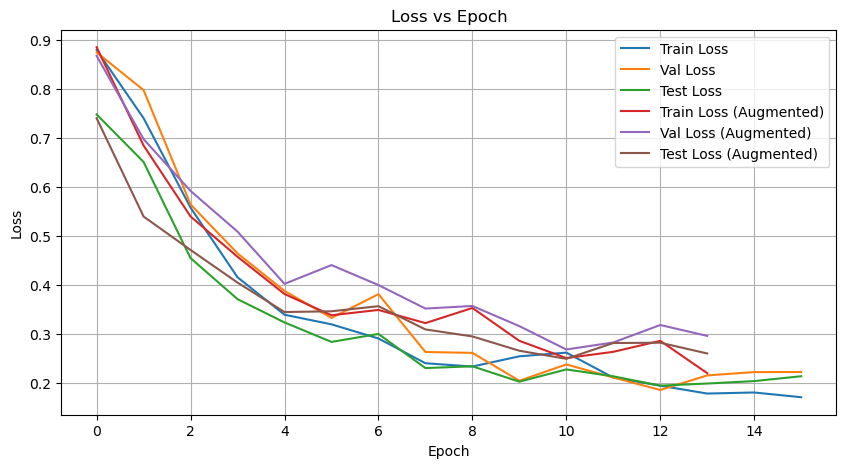

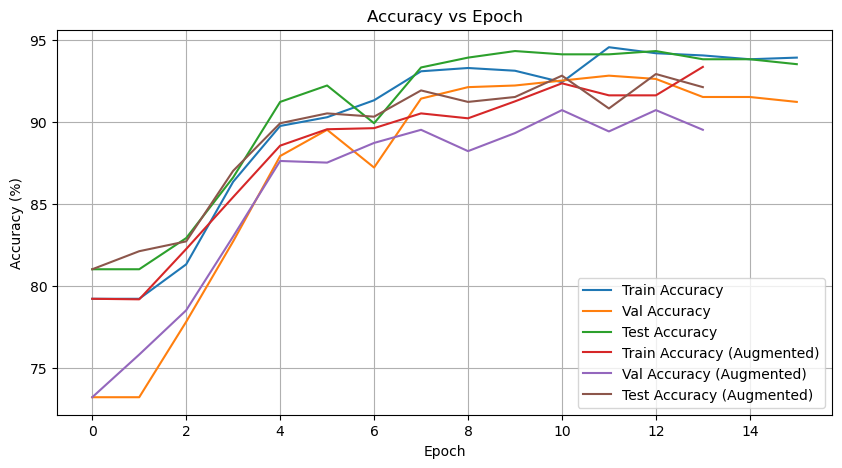

In [5]:
#plot the training, validation and test accuracies and losses for both the models together

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot(test_losses, label='Test Loss')
plt.plot(aug_train_losses, label='Train Loss (Augmented)')
plt.plot(aug_val_losses, label='Val Loss (Augmented)')
plt.plot(aug_test_losses, label='Test Loss (Augmented)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(aug_train_accuracies, label='Train Accuracy (Augmented)')
plt.plot(aug_val_accuracies, label='Val Accuracy (Augmented)')
plt.plot(aug_test_accuracies, label='Test Accuracy (Augmented)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid()
plt.show()


## 3. Mono-Color Training

In this task, the input images will be converted to gray-scale. Then the model will be trained on the new input data. The motivation of this exercise is to examine whether the color is necessary to train the model.

*Task Output*: Repeat the training process with gray-scale images instead of RGB data. For that purpose, the 5000 images have to be converted into gray-scale off-line or on-line when fetching a mini-batch. The training should be conducted without augmentation. The output of the exercise should be a plot of the training, validation and test set loss over time and the accuracy over time. The model has to be trained with early stopping using _min_delta=0.0_ and _patience=3_. Finally, the loss and accuracy of training with RGB and gray-scale images should be visualized in the same plot.

*Important*: The scripts should be **self-contained**. The data augmentation should be dynamically implemented, i.e it is applied when the mini-batch is loaded.

In [6]:
#modify the previously defined dataset class to include convertion to grayscale

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import random
from torchvision import transforms
from PIL import Image

class CarRacingDataset(Dataset):
    def __init__(self, npz_file, augmentations=True, horizontal_flip=False, random_rotation=False, vertical_flip=False, street_color_change=False):
        """
        Args:
            npz_file (str): Path to the .npz file containing 'frames' and 'actions'.
            augmentations (bool): Whether to apply augmentations.
            horizontal_flip (bool): Whether to apply horizontal flip.
            random_rotation (bool): Whether to apply random rotation (up to 20 degrees).
            vertical_flip (bool): Whether to apply vertical flip.
            street_color_change (bool): Whether to apply street color change.
        """
        data = np.load(npz_file)
        self.frames = data['frames']
        self.actions = data['actions']
        self.augmentations = augmentations
        self.horizontal_flip = horizontal_flip
        self.random_rotation = random_rotation
        self.vertical_flip = vertical_flip
        self.street_color_change = street_color_change
        self.to_pil = transforms.ToPILImage()
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.frames)

    def _apply_horizontal_flip(self, image):
        # Modified to use 20% probability as specified in the task
        if random.random() < 0.2 and self.horizontal_flip and self.augmentations:
            return image.transpose(Image.FLIP_LEFT_RIGHT)
        return image

    def _apply_random_rotation(self, image):
        # New augmentation method for random rotation up to 20 degrees
        if random.random() < 0.2 and self.random_rotation and self.augmentations:
            angle = random.uniform(-20, 20)  # Random angle between -20 and 20 degrees
            return image.rotate(angle)
        return image

    def _apply_vertical_flip(self, image):
        if random.random() < 0.2 and self.vertical_flip and self.augmentations:
            return image.transpose(Image.FLIP_TOP_BOTTOM)
        return image

    def _apply_street_color_change(self, image):
        if random.random() < 0.2 and self.street_color_change and self.augmentations:
            # Define the gray and brown color ranges
            gray_min = [100, 100, 100]
            gray_max = [150, 150, 150]
            brown_min = [90, 60, 30]
            brown_max = [150, 100, 60]

            img_np = np.array(image)
            mask = np.all((img_np >= gray_min) & (img_np <= gray_max), axis=2)
            # Generate a random brown color for each channel independently
            brown_color = np.array([random.randint(brown_min[i], brown_max[i]) for i in range(3)], dtype=np.uint8)
            img_np[mask] = brown_color
            return Image.fromarray(img_np)
        return image
    
    def __getitem__(self, idx):
        frame = self.frames[idx]
        action = self.actions[idx]

        image = self.to_pil(frame)

        image = self._apply_horizontal_flip(image)
        image = self._apply_random_rotation(image)
        image = self._apply_vertical_flip(image)
        image = self._apply_street_color_change(image)

        # Convert to grayscale (1 channel)
        image = transforms.functional.to_grayscale(image, num_output_channels=1)

        # Convert to tensor
        image = self.to_tensor(image)

        action = torch.tensor(action, dtype=torch.float32)

        return image, action


Using device: cuda
Train size: 3000, Validation size: 1000, Test size: 1000
Epoch 1: Train Loss=0.8634, Val Loss=0.8638, Val Acc=73.20%
Test Loss: 0.7274, Test Accuracy: 81.00%
Epoch 2: Train Loss=0.7472, Val Loss=0.7837, Val Acc=73.20%
Test Loss: 0.6359, Test Accuracy: 81.00%
Epoch 3: Train Loss=0.5703, Val Loss=0.5962, Val Acc=79.70%
Test Loss: 0.4788, Test Accuracy: 83.90%
Epoch 4: Train Loss=0.4650, Val Loss=0.5340, Val Acc=79.40%
Test Loss: 0.4375, Test Accuracy: 83.90%
Epoch 5: Train Loss=0.4176, Val Loss=0.4497, Val Acc=82.60%
Test Loss: 0.3737, Test Accuracy: 85.90%
Epoch 6: Train Loss=0.3590, Val Loss=0.3782, Val Acc=87.50%
Test Loss: 0.3240, Test Accuracy: 90.20%
Epoch 7: Train Loss=0.3170, Val Loss=0.3166, Val Acc=89.90%
Test Loss: 0.2816, Test Accuracy: 91.70%
Epoch 8: Train Loss=0.2681, Val Loss=0.2969, Val Acc=90.90%
Test Loss: 0.2706, Test Accuracy: 92.70%
Epoch 9: Train Loss=0.2550, Val Loss=0.2715, Val Acc=91.50%
Test Loss: 0.2588, Test Accuracy: 93.20%
Epoch 10: Train

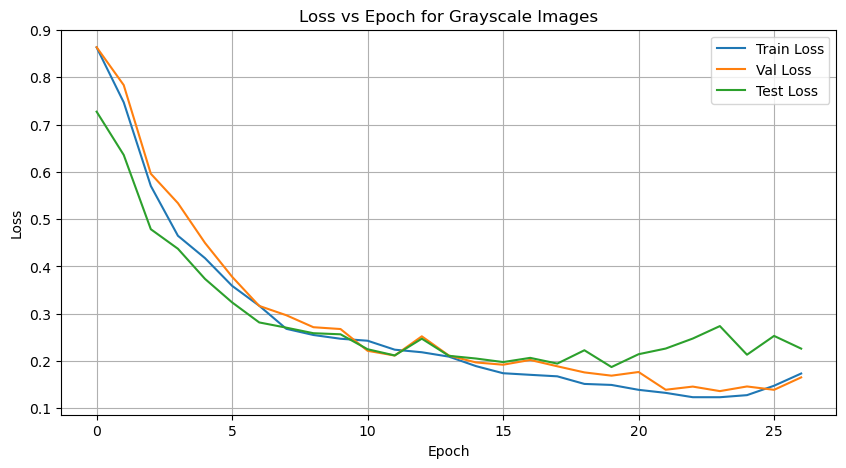

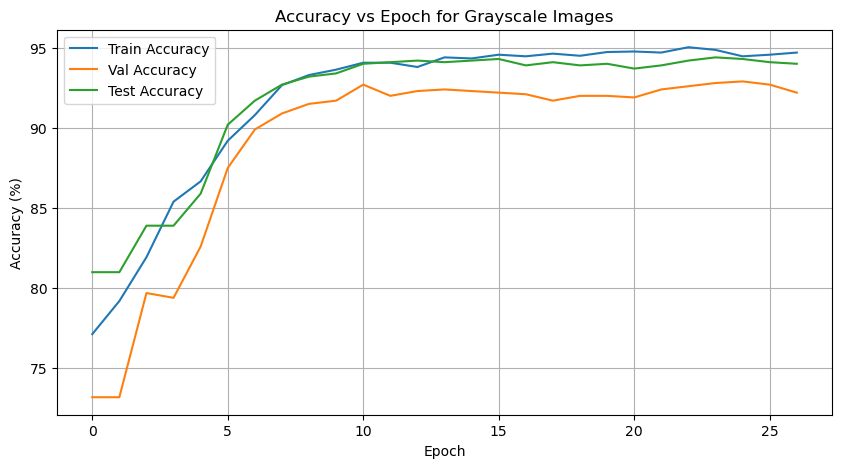

In [7]:
#define network architecture

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import numpy as np

npz_file_path = 'all_episodes_disc.npz'

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define CNN model for 96x96 images and 5 class o/p
class CarCNN(nn.Module):
    def __init__(self):
        super(CarCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 5, stride=2, padding=2),  # Changed from 3 to 1 for grayscale
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 128),
            nn.ReLU(),
            nn.Linear(128, 5)  # 5 classes
        )

    def forward(self, x):
        return self.net(x)

    
dataset = CarRacingDataset(
        npz_file=npz_file_path,
        augmentations=False, #making augmentations to false here renders the other parameters useless
        horizontal_flip=True,
        vertical_flip=False,
        random_rotation=True,
        street_color_change=False
    )
    
# Split the dataset into train, validation, and test sets
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size+val_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size+val_size, len(dataset)))

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, optimizer, and loss function
model = CarCNN().to(device)
LR = 0.001
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

#configure the early stopping criterion
patience = 3
min_delta = 0.0
best_val_loss = float('inf')
patience_counter = 0

# Training loop
num_epochs = 50
gray_train_losses, gray_val_losses, gray_test_losses = [], [], []
gray_train_accuracies, gray_val_accuracies, gray_test_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.long().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    gray_train_losses.append(train_loss / len(train_loader))
    gray_train_accuracies.append(100 * correct / total)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.long().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    gray_val_losses.append(val_loss)
    gray_val_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}: Train Loss={gray_train_losses[-1]:.4f}, Val Loss={val_loss:.4f}, Val Acc={gray_val_accuracies[-1]:.2f}%")

    # Test evaluation
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.long().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1) # alternatively: apply softmax if we need probabilities of all the 5 classes
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    gray_test_losses.append(test_loss)
    gray_test_accuracies.append(test_accuracy)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Early stopping
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Save the model
torch.save(model.state_dict(), 'driving_model_gray.pth')

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(gray_train_losses, label='Train Loss')
plt.plot(gray_val_losses, label='Val Loss')
plt.plot(gray_test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch for Grayscale Images')
plt.legend()
plt.grid()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(gray_train_accuracies, label='Train Accuracy')
plt.plot(gray_val_accuracies, label='Val Accuracy')
plt.plot(gray_test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch for Grayscale Images')
plt.legend()
plt.grid()
plt.show()

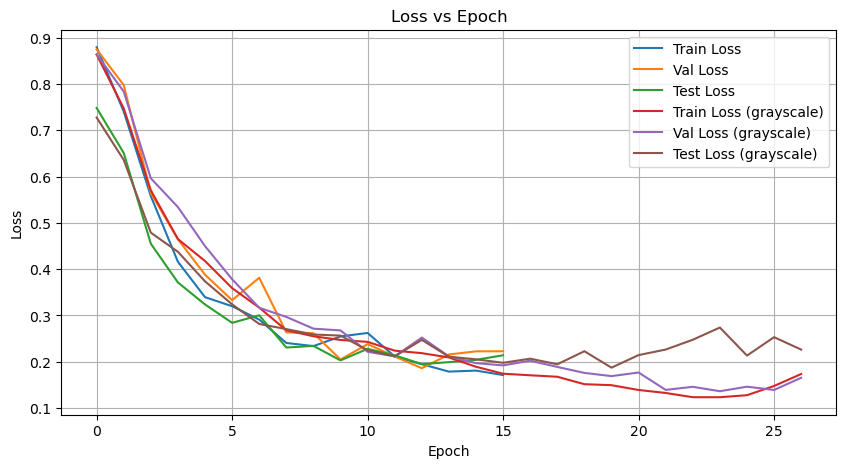

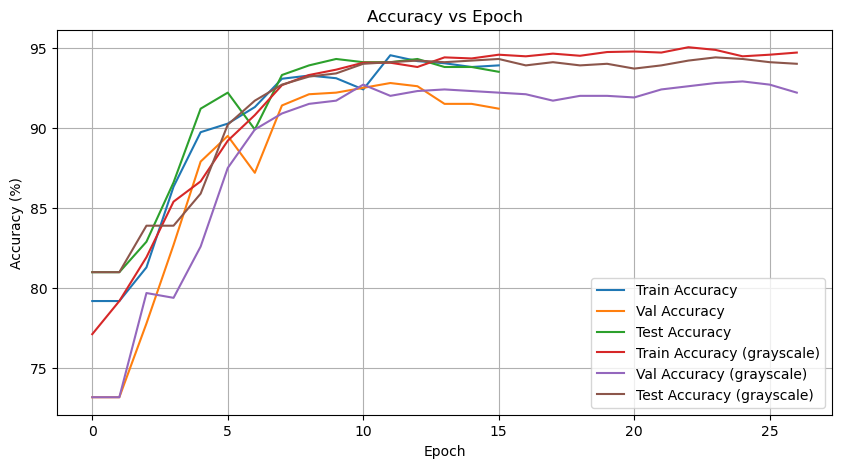

In [8]:
#plot the training, validation and test accuracies and losses for both the models together (RGB + grayscale)

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot(test_losses, label='Test Loss')
plt.plot(gray_train_losses, label='Train Loss (grayscale)')
plt.plot(gray_val_losses, label='Val Loss (grayscale)')
plt.plot(gray_test_losses, label='Test Loss (grayscale)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(gray_train_accuracies, label='Train Accuracy (grayscale)')
plt.plot(gray_val_accuracies, label='Val Accuracy (grayscale)')
plt.plot(gray_test_accuracies, label='Test Accuracy (grayscale)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid()
plt.show()
